### Quality Control 质控

In [1]:
import numpy as np
import scanpy as sc
import seaborn as sns
from scipy.stats import median_abs_deviation

sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    frameon=False,
)

In [4]:
adata = sc.read_10x_h5(
    filename="filtered_feature_bc_matrix.h5",
    backup_url="https://figshare.com/ndownloader/files/39546196",
)
adata

100%|██████████| 163M/163M [02:14<00:00, 1.27MB/s] 
e:\Anaconda\envs\scai\lib\site-packages\anndata\_core\anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
e:\Anaconda\envs\scai\lib\site-packages\anndata\_core\anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 16934 × 36601
    var: 'gene_ids', 'feature_types', 'genome', 'interval'

将数字字符串附加到每个重复的索引元素：“1”、“2”等来使变量名称唯一

In [5]:
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 16934 × 36601
    var: 'gene_ids', 'feature_types', 'genome', 'interval'

##### 过滤低质量的读数reads

In [6]:
# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes.
adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))

In [7]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)
adata

AnnData object with n_obs × n_vars = 16934 × 36601
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

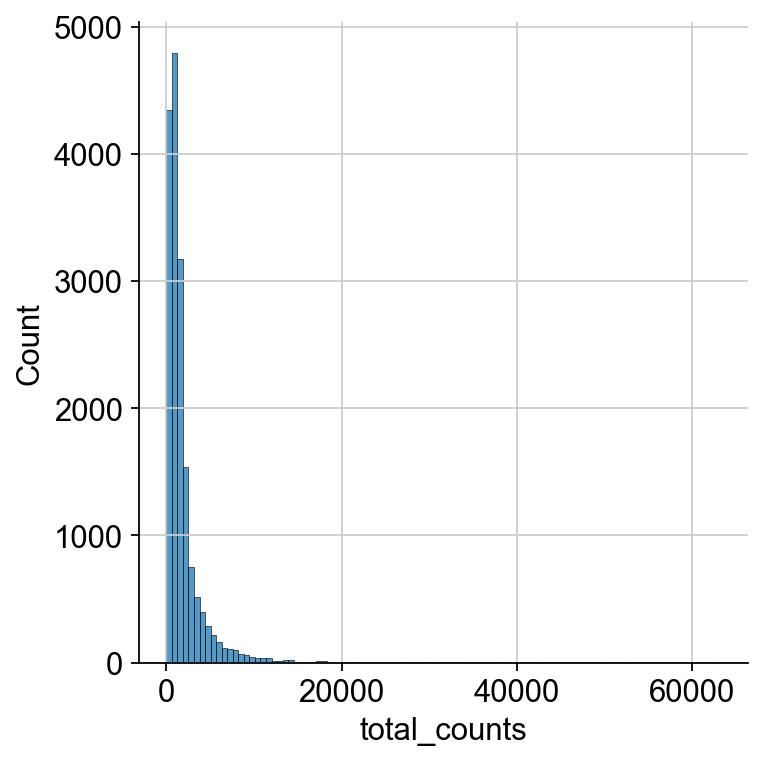

In [13]:
#绘制单细胞数据中每个细胞的总UMI数（total_counts）的分布直方图
p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False)

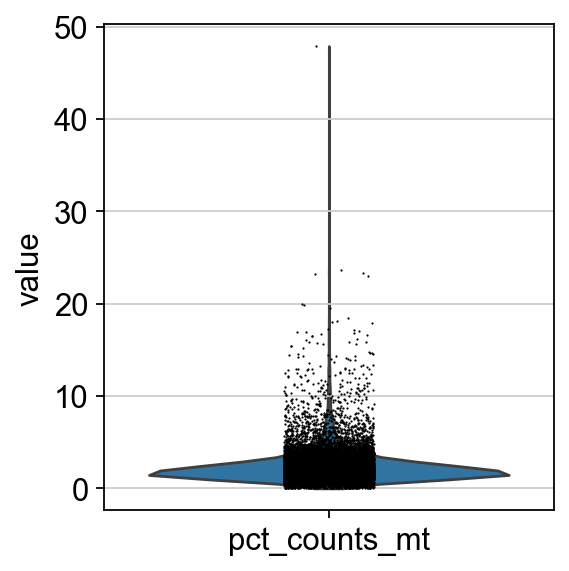

In [12]:
#线粒体基因表达占比的分布特征
p2 = sc.pl.violin(adata, "pct_counts_mt")

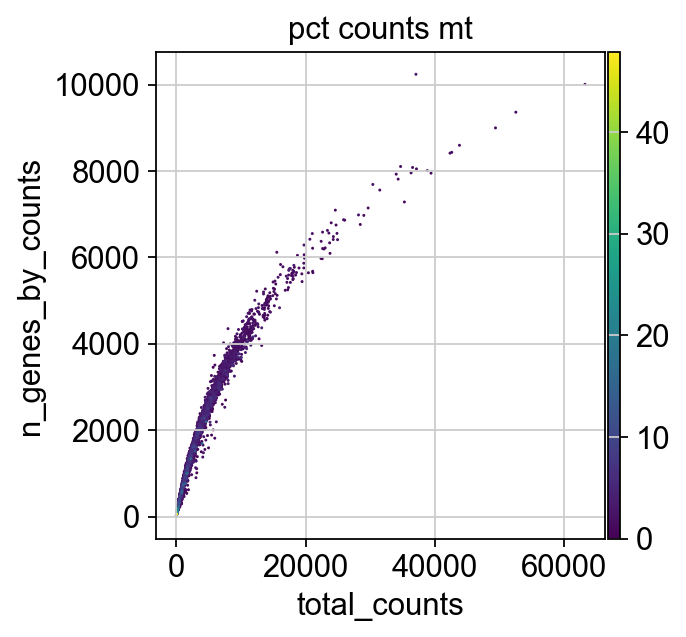

In [14]:
# 分布散点图
p3 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [15]:
# 设置阈值参数（需根据数据分布调整）
min_genes = 200          # 最低检测基因数
max_genes = 6000         # 最高检测基因数（防双细胞）
min_counts = 1000        # 最低总UMI数
max_counts = 50000       # 最高总UMI数
max_mt = 15              # 线粒体基因占比阈值（%）
max_hb = 1               # 血红蛋白基因占比阈值（%）

# 联合过滤条件
cell_filter = (
    (adata.obs["n_genes_by_counts"] > min_genes) &
    (adata.obs["n_genes_by_counts"] < max_genes) &
    (adata.obs["total_counts"] > min_counts) &
    (adata.obs["total_counts"] < max_counts) &
    (adata.obs["pct_counts_mt"] < max_mt) &
    (adata.obs["pct_counts_hb"] < max_hb)
)

# 应用过滤
adata = adata[cell_filter, :]

In [16]:
# 去除在少于3个细胞中表达的基因
sc.pp.filter_genes(adata, min_cells=3)

e:\Anaconda\envs\scai\lib\site-packages\scanpy\preprocessing\_simple.py:283: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


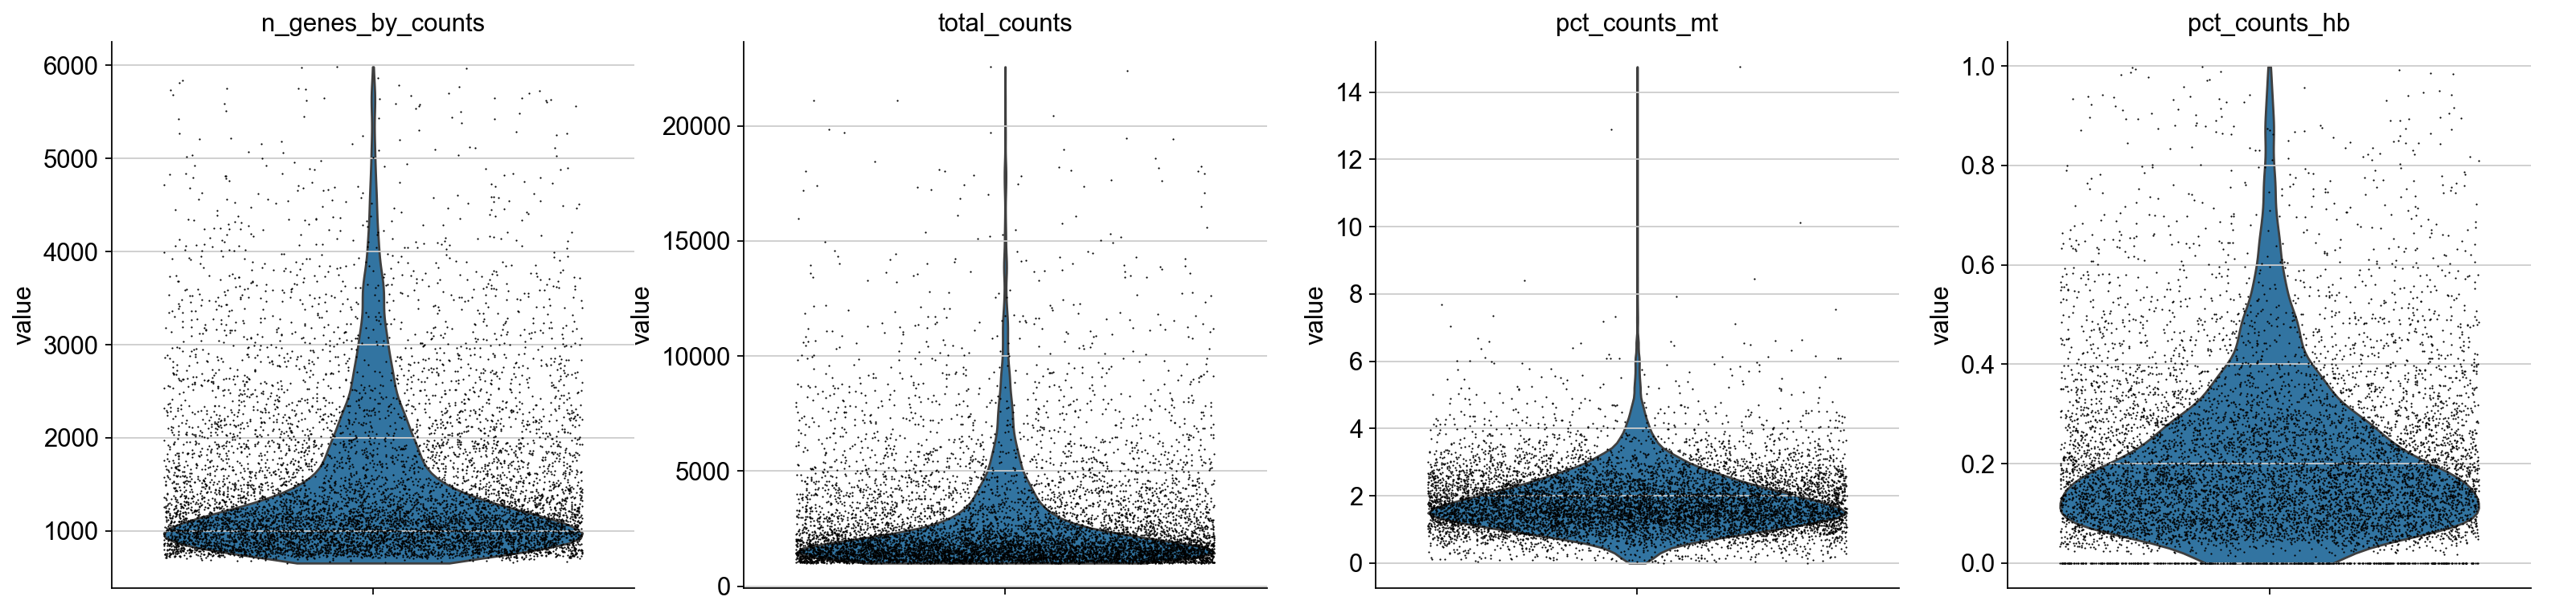

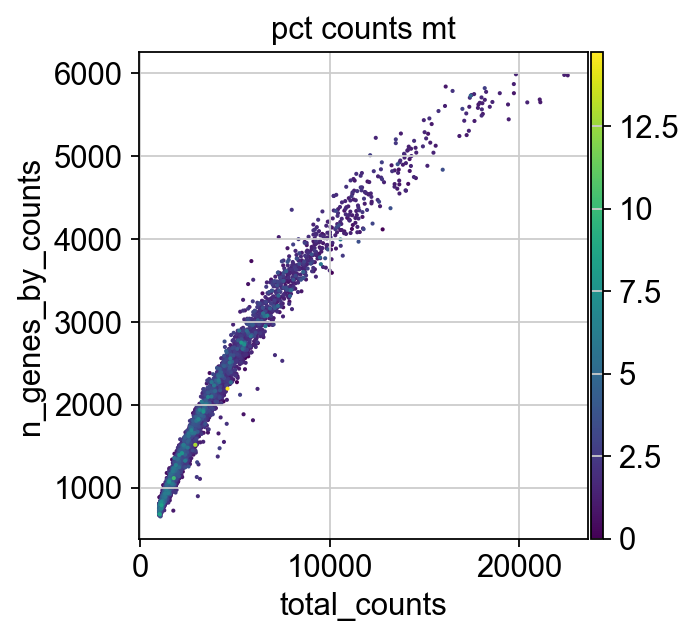

In [18]:
# 过滤后的小提琴图
sc.pl.violin(
    adata, 
    ["n_genes_by_counts", "total_counts", "pct_counts_mt", "pct_counts_hb"],
    jitter=0.4, 
    multi_panel=True,
    save="_filtered.png"  # 保存图像
)

# 过滤后的联合散点图
sc.pl.scatter(
    adata, 
    "total_counts", 
    "n_genes_by_counts", 
    color="pct_counts_mt",
    color_map="viridis",
    save="_filtered_scatter.png"
)